In [49]:
import random

import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
from torch.optim.lr_scheduler import StepLR

torch.__version__

'1.11.0+cu102'

In [2]:
class SingleCellDataset(Dataset):
    def __init__(self, file_name):
        self.adata = sc.read(file_name)
        self.x = self.adata.X
 
    def __len__(self):
        return len(self.x)
   
    def __getitem__(self,idx):
        return self.x[idx]


dataset = SingleCellDataset('./brain_normalized.h5ad')

In [3]:
batch_size = 64
dataloader = DataLoader(dataset, shuffle=True, batch_size=batch_size)
len(dataloader)

51

In [4]:
example_x = next(iter(dataloader))
example_x.shape

torch.Size([64, 18585])

In [5]:
example_x

tensor([[-0.0809, -1.4846, -0.5763,  ...,  3.1135, -0.0438,  1.7132],
        [-0.0809,  0.7202, -0.5763,  ...,  2.2497, -0.0438, -0.6812],
        [-0.0809,  1.1929, -0.5763,  ..., -0.5655, -0.0438, -0.6812],
        ...,
        [-0.0809, -1.4846, -0.5763,  ...,  0.0479, -0.0438,  1.8086],
        [14.3532, -0.3237, -0.5763,  ..., -0.5655, -0.0438,  0.1548],
        [-0.0809,  0.7275, -0.5763,  ..., -0.5655, -0.0438,  0.4428]])

In [6]:
device = 'cuda'

In [7]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(18585, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.Tanh(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 18585),
        )
        
    def forward(self, x):
        z = self.encoder(x)
        y = self.decoder(z)
        return y
        

model = AutoEncoder().to(device)
y = model(example_x.to(device))
y.shape

torch.Size([64, 18585])

In [8]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2.5e-4)
# scheduler = StepLR(optimizer, step_size=10, gamma=0.9)

In [10]:
def train(dataloader, optimizer):
    size = len(dataloader.dataset)
    model.train()
    losses = []
    for batch, X in enumerate(dataloader):
        X = X.to(device)

        X_pred = model(X)
        loss = loss_fn(X_pred, X)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss)
    return torch.mean(torch.FloatTensor(losses))


EPOCHS = 1000
for epoch in range(1, EPOCHS + 1):
    loss = train(dataloader, optimizer)
    print(f'loss: {loss:>7f}')
    # scheduler.step()

loss: 0.903868
loss: 0.892628
loss: 0.880094
loss: 0.875506
loss: 0.869270
loss: 0.865536
loss: 0.862749
loss: 0.857780
loss: 0.855824
loss: 0.854941
loss: 0.853680
loss: 0.848796
loss: 0.847765
loss: 0.849389
loss: 0.850625
loss: 0.844870
loss: 0.841722
loss: 0.842816
loss: 0.840484
loss: 0.839516
loss: 0.836458
loss: 0.839345
loss: 0.834331
loss: 0.833079
loss: 0.831114
loss: 0.837212
loss: 0.828610
loss: 0.830164
loss: 0.829072
loss: 0.825549
loss: 0.829270
loss: 0.823075
loss: 0.820538
loss: 0.820448
loss: 0.816999
loss: 0.814593
loss: 0.810409
loss: 0.808317
loss: 0.808698
loss: 0.809130
loss: 0.806479
loss: 0.802659
loss: 0.803392
loss: 0.802781
loss: 0.799890
loss: 0.799103
loss: 0.799958
loss: 0.798273
loss: 0.794784
loss: 0.793002
loss: 0.788350
loss: 0.786253
loss: 0.783049
loss: 0.782115
loss: 0.781592
loss: 0.777423
loss: 0.777274
loss: 0.773539
loss: 0.771739
loss: 0.770003
loss: 0.771266
loss: 0.769593
loss: 0.770103
loss: 0.763914
loss: 0.759563
loss: 0.757038
loss: 0.75

In [28]:
adata = sc.read('./brain_normalized.h5ad')

In [29]:
adata.X.shape

(3210, 18585)

In [32]:
adata.obs.shape

(3210, 7)

In [36]:
def encode_data(x, encoder):
    encoder.eval()
    encoded = []
    for row in x:
        r = torch.tensor(row).to(device)
        encoded.append(encoder(r).cpu().detach().numpy())
    return np.stack(encoded, axis=0)


encoded = encode_data(adata.X, model.encoder)
encoded.shape

(3210, 128)

In [37]:
encoded

array([[ 1.        , -1.        , -1.        , ...,  1.        ,
         1.        , -1.        ],
       [ 1.        ,  1.        , -1.        , ..., -0.99982274,
         1.        ,  1.        ],
       [-0.99999684,  1.        ,  0.9999098 , ...,  1.        ,
         1.        ,  1.        ],
       ...,
       [ 1.        ,  1.        , -1.        , ...,  1.        ,
         1.        ,  1.        ],
       [-0.9999241 ,  1.        ,  0.9725072 , ...,  1.        ,
         0.9999987 ,  1.        ],
       [ 1.        ,  1.        , -1.        , ...,  0.9999397 ,
         1.        ,  1.        ]], dtype=float32)

In [46]:
ontology_classes = list(adata.obs.loc[:, 'cell_ontology_class'].unique())
ontology_classes

['astrocyte',
 'oligodendrocyte',
 'endothelial cell',
 'neuron',
 'oligodendrocyte precursor cell',
 'Bergmann glial cell',
 'brain pericyte']

In [53]:
color_mapping = {c: "#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for c in ontology_classes}
color_mapping

{'astrocyte': '#081EC4',
 'oligodendrocyte': '#EDE2AB',
 'endothelial cell': '#185D94',
 'neuron': '#7436D1',
 'oligodendrocyte precursor cell': '#4CC637',
 'Bergmann glial cell': '#EFB201',
 'brain pericyte': '#C253DE'}

In [54]:
colors = [color_mapping[c] for c in np.array(adata.obs.loc[:, 'cell_ontology_class'])]
colors

['#081EC4',
 '#081EC4',
 '#EDE2AB',
 '#185D94',
 '#081EC4',
 '#EDE2AB',
 '#185D94',
 '#7436D1',
 '#185D94',
 '#185D94',
 '#185D94',
 '#4CC637',
 '#081EC4',
 '#4CC637',
 '#185D94',
 '#EDE2AB',
 '#EDE2AB',
 '#EDE2AB',
 '#185D94',
 '#EDE2AB',
 '#185D94',
 '#4CC637',
 '#4CC637',
 '#7436D1',
 '#EDE2AB',
 '#185D94',
 '#EFB201',
 '#EDE2AB',
 '#185D94',
 '#7436D1',
 '#081EC4',
 '#4CC637',
 '#185D94',
 '#185D94',
 '#EDE2AB',
 '#185D94',
 '#7436D1',
 '#4CC637',
 '#081EC4',
 '#EDE2AB',
 '#EDE2AB',
 '#EDE2AB',
 '#EDE2AB',
 '#185D94',
 '#185D94',
 '#7436D1',
 '#081EC4',
 '#EDE2AB',
 '#7436D1',
 '#081EC4',
 '#EDE2AB',
 '#185D94',
 '#185D94',
 '#EDE2AB',
 '#185D94',
 '#185D94',
 '#EDE2AB',
 '#EDE2AB',
 '#7436D1',
 '#C253DE',
 '#EDE2AB',
 '#C253DE',
 '#7436D1',
 '#EDE2AB',
 '#C253DE',
 '#185D94',
 '#081EC4',
 '#C253DE',
 '#185D94',
 '#185D94',
 '#185D94',
 '#7436D1',
 '#081EC4',
 '#185D94',
 '#EDE2AB',
 '#EDE2AB',
 '#7436D1',
 '#4CC637',
 '#185D94',
 '#EDE2AB',
 '#081EC4',
 '#185D94',
 '#7436D1',
 '#7

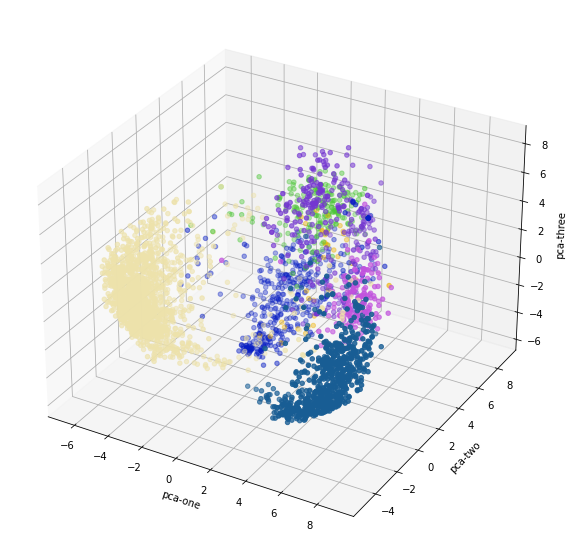

In [57]:
pca = PCA(n_components=3)
embedded_pca = pca.fit_transform(encoded)

plt.figure(figsize=(16,10))
ax = plt.axes(projection='3d')
ax.scatter(
    xs=embedded_pca[:, 0],
    ys=embedded_pca[:, 1],
    zs=embedded_pca[:, 2],
    c=colors,
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3210 samples in 0.000s...
[t-SNE] Computed neighbors for 3210 samples in 0.153s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3210
[t-SNE] Computed conditional probabilities for sample 2000 / 3210
[t-SNE] Computed conditional probabilities for sample 3000 / 3210
[t-SNE] Computed conditional probabilities for sample 3210 / 3210
[t-SNE] Mean sigma: 2.516586
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.442154
[t-SNE] KL divergence after 1000 iterations: 1.041163


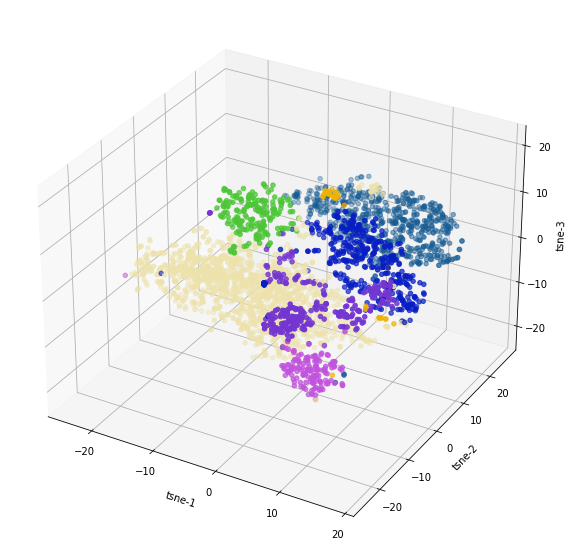

In [59]:
tsne = TSNE(n_components=3, init='random', random_state=5, verbose=1)
embedded_tsne = tsne.fit_transform(encoded)

plt.figure(figsize=(16,10))
ax = plt.axes(projection='3d')
ax.scatter(
    xs=embedded_tsne[:, 0],
    ys=embedded_tsne[:, 1],
    zs=embedded_tsne[:, 2],
    c=colors,
)
ax.set_xlabel('tsne-1')
ax.set_ylabel('tsne-2')
ax.set_zlabel('tsne-3')
plt.show()